## Importing modules

In [1]:
from apex import amp
amp_handle = amp.init(enabled=True)
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

## Omitting the fastai progress bar

In [2]:
import fastai
# from fastprogress import force_console_behavior
# import fastprogress
# fastprogress.fastprogress.NO_BAR = True
# master_bar, progress_bar = force_console_behavior()
# fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
df = pd.read_csv('data/train-extracted.csv')
val_fns = {'69823499d.jpg'}

In [4]:
fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [5]:
name = f'res50-full-train'

In [6]:
SZ = 448
BS = 40
NUM_WORKERS = 12
SEED=0

## Image Augmentation
Here I do show the augmentations that are going to be done on the images

In [7]:
# tfms = get_transforms(max_rotate = 25, do_flip = True, flip_vert = False)
tfms = get_transforms(max_warp=0.2, max_lighting=0.2, max_rotate=25, do_flip=True, flip_vert=False, max_zoom=1.1)

In [14]:
data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train-extracted-448', cols=['Image'])
        .random_split_by_pct(valid_pct=0.001, seed=SEED)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test-extracted-448'))
        .transform(get_transforms(tfms), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
w_b874a6f, w_310226c, w_ff22dd7
  if getattr(ds, 'warn', False): warn(ds.warn)


In [15]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (15679 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, Category w_dd88965, Category w_64404ac]...
Path: data/train-extracted-448
x: ImageItemList (15679 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Valid: LabelList
y: CategoryList (12 items)
[Category w_4bf625b, Category w_c8d5ad5, Category w_4af7c01, Category w_fd906cc, Category w_4d62749]...
Path: data/train-extracted-448
x: ImageItemList (12 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Test: LabelList
y: EmptyLabelList (7959 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7959 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train

## Train the network the whale fluke shape
Here I train the model with most of the dataset to expose the model to the all the whales 

In [16]:
%%time
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(14, 1e-2)
learn.save(f'{name}-stage-1.2')


learn.unfreeze()


max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(24, lrs)
learn.save(f'{name}-stage-2.2')

epoch,train_loss,valid_loss
1,7.325742,7.257142
2,6.708625,7.088633
3,5.934584,5.103212
4,5.219306,6.497177
5,4.447459,4.176364
6,3.823574,3.652051
7,3.104658,2.802022
8,2.443679,3.933354
9,1.658901,3.837400
10,1.162529,3.035851


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


epoch,train_loss,valid_loss
1,0.192850,2.718432
2,0.211671,2.470974
3,0.316844,3.044542
4,0.418241,2.703936
5,0.518434,2.008351
6,0.559094,2.222085
7,0.559348,2.550799
8,0.505269,2.387050
9,0.473425,2.499254
10,0.448322,2.655263


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


CPU times: user 1h 18min 54s, sys: 33min 24s, total: 1h 52min 18s
Wall time: 1h 53min 55s


In [16]:
%%time
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();

learn.fit_one_cycle(14, 1e-2)
learn.save(f'{name}-stage-1.2')


learn.unfreeze()


max_lr = 1e-3
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(24, lrs)
learn.save(f'{name}-stage-2.2')

epoch,train_loss,valid_loss
1,7.325742,7.257142
2,6.708625,7.088633
3,5.934584,5.103212
4,5.219306,6.497177
5,4.447459,4.176364
6,3.823574,3.652051
7,3.104658,2.802022
8,2.443679,3.933354
9,1.658901,3.837400
10,1.162529,3.035851


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


epoch,train_loss,valid_loss
1,0.192850,2.718432
2,0.211671,2.470974
3,0.316844,3.044542
4,0.418241,2.703936
5,0.518434,2.008351
6,0.559094,2.222085
7,0.559348,2.550799
8,0.505269,2.387050
9,0.473425,2.499254
10,0.448322,2.655263


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


CPU times: user 1h 18min 54s, sys: 33min 24s, total: 1h 52min 18s
Wall time: 1h 53min 55s


## Unfreeze
Unfreeze and pretrain the full network on the 224 images

## Train on larger images

Now we train the network on larger images 448 images.

In [16]:
SZ = 224 * 2
BS = 128 // 4
NUM_WORKERS = 12
SEED=0

In [17]:


data = (
    ImageItemList
        .from_df(df[df.Id != 'new_whale'], 'data/train-extracted-448', cols=['Image'])
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test-extracted-448'))
        .transform(get_transforms(tfms), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)



/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:474: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the folowing unknown labels, the corresponding items have been discarded.
w_dc4c211, w_45e277d, w_17c9df5, w_18645ff, w_06ffb30...
  if getattr(ds, 'warn', False): warn(ds.warn)


In [18]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (12556 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, Category w_dd88965, Category w_64404ac]...
Path: data/train-extracted-448
x: ImageItemList (12556 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Valid: LabelList
y: CategoryList (2615 items)
[Category w_4bf625b, Category w_c8d5ad5, Category w_4af7c01, Category w_fd906cc, Category w_4d62749]...
Path: data/train-extracted-448
x: ImageItemList (2615 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Test: LabelList
y: EmptyLabelList (7959 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7959 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/t

## Recreate the model

In [19]:
%%time
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], metrics=accuracy)

CPU times: user 5.06 s, sys: 164 ms, total: 5.22 s
Wall time: 793 ms


## Load Previous Model

In [20]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], metrics=accuracy)
learn.clip_grad();
learn.load(f'{name}-stage-2.2')
learn.freeze_to(-1)
learn.fit_one_cycle(4, 1e-2 / 4)
learn.save(f'{name}-stage-3.2')

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(6, lrs)
learn.save(f'{name}-stage-4.2')

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([5001, 2048]) from checkpoint, the shape in current model is torch.Size([4542, 2048]).
	size mismatch for 1.8.bias: copying a param with shape torch.Size([5001]) from checkpoint, the shape in current model is torch.Size([4542]).

In [44]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [32, 64, 224, 224]   9408       False     \n______________________________________________________________________\nBatchNorm2d          [32, 64, 224, 224]   128        True      \n______________________________________________________________________\nReLU                 [32, 64, 224, 224]   0          False     \n______________________________________________________________________\nMaxPool2d            [32, 64, 112, 112]   0          False     \n______________________________________________________________________\nConv2d               [32, 64, 112, 112]   4096       False     \n______________________________________________________________________\nBatchNorm2d          [32, 64, 112, 112]   128        True      \n________________________________________

In [21]:

learn.fit_one_cycle(4, 1e-2 / 4)
learn.save(f'{name}-stage-3.2')

learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(6, lrs)
learn.save(f'{name}-stage-4.2')

epoch,train_loss,valid_loss
1,0.441058,0.000043
2,0.335823,0.000000


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


KeyboardInterrupt: 

In [9]:
# tfms[1]

In [10]:
# with oversampling
df = pd.read_csv('data/oversampled_train_and_val.csv')

val_fns = {'69823499d.jpg'}

## Retrain with validation on the Oversampled 

In [11]:


data = (
    ImageItemList
        .from_df(df, 'data/train-extracted-448', cols=['Image'])
        .random_split_by_pct(seed=SEED)
        .label_from_func(lambda path: fn2label[path2fn(path)])
        .add_test(ImageItemList.from_folder('data/test-extracted-448'))
        .transform(get_transforms(tfms), size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats)
)



In [19]:
data

ImageDataBunch;

Train: LabelList
y: CategoryList (61029 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train-extracted-448
x: ImageItemList (61029 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Valid: LabelList
y: CategoryList (15257 items)
[Category w_b99f945, Category w_50b08a9, Category w_17a108a, Category w_28218e1, Category w_698fcbe]...
Path: data/train-extracted-448
x: ImageItemList (15257 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Test: LabelList
y: EmptyLabelList (7959 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7959 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data

## Don't do it again

In [23]:
%%time
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();
# learn.load(f'{name}-stage-2.2')
# learn.freeze_to(-1)

learn.fit_one_cycle(6, 1e-2 / 4)
learn.save(f'{name}-stage-7.2')

learn.unfreeze()

learn.fit_one_cycle(8, 1e-2 / 4)
learn.save(f'{name}-stage-8.1')

epoch,train_loss,valid_loss
1,3.996310,3.049559
2,1.600495,0.823579
3,0.706916,0.242066
4,0.288339,0.105518
5,0.102089,0.062937
6,0.045572,0.059900


Gradient overflow, skipping update


epoch,train_loss,valid_loss
1,1.833403,1.086232
2,1.692323,1.140006
3,0.916619,0.414363
4,0.540050,0.155820
5,0.267016,0.078707
6,0.115443,0.049588
7,0.040116,0.038544
8,0.024115,0.036141


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


CPU times: user 1h 59min 54s, sys: 51min 7s, total: 2h 51min 1s
Wall time: 2h 51min 57s


In [13]:
BS

40

In [15]:
%%time 
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048], metrics=accuracy)
learn.clip_grad();
learn.load(f'{name}-stage-8.1')
learn.fit_one_cycle(3, 1e-2 / 4)
learn.save(f'{name}-stage-8.2')

epoch,train_loss,valid_loss,accuracy
1,0.308402,0.087659,0.984532
2,0.158781,0.050845,0.992200
3,0.044565,0.038983,0.993773


Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


CPU times: user 21min 19s, sys: 9min 29s, total: 30min 49s
Wall time: 30min 57s


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


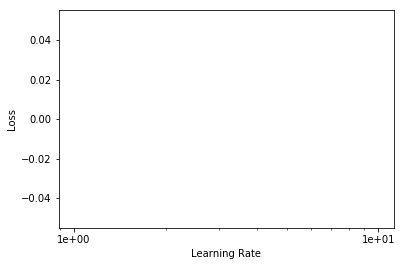

In [16]:
learn.lr_find()
learn.recorder.plot()

In [80]:
%%time
# learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
# learn.clip_grad();
# learn.load(f'{name}-stage-4.1')
# learn.freeze_to(-1)

learn.fit_one_cycle(2, 1e-2 / 4)
learn.save(f'{name}-stage-5.1')

epoch     train_loss  valid_loss


Gradient overflow, skipping update


1         0.192471    0.000000    


Gradient overflow, skipping update


2         0.117598    0.000000    
CPU times: user 3min 9s, sys: 1min 22s, total: 4min 31s
Wall time: 4min 35s


In [28]:
%time
# learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
# learn.clip_grad();
# learn.load(f'{name}-stage-5.1')
learn.unfreeze()

max_lr = 1e-3 / 4
lrs = [max_lr/100, max_lr/10, max_lr]

learn.fit_one_cycle(3, lrs)
learn.save(f'{name}-stage-6.1')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs
epoch     train_loss  valid_loss


Gradient overflow, skipping update


1         0.009794    0.000000    
2         0.018557    0.000000    


Gradient overflow, skipping update
Gradient overflow, skipping update


3         0.016451    0.000000    


Gradient overflow, skipping update


4         0.014324    0.000000    


Gradient overflow, skipping update


5         0.019439    0.000000    


Gradient overflow, skipping update


6         0.008128    0.000000    


Gradient overflow, skipping update


7         0.004235    0.000000    


Gradient overflow, skipping update


8         0.007592    0.000000    
9         0.001784    0.000000    


Gradient overflow, skipping update


10        0.003254    0.000000    


# Predict 

In [174]:
learn = create_cnn(data, models.resnet50, lin_ftrs=[2048])
learn.clip_grad();
learn.load(f'{name}-stage-8.1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (61029 items)
[Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639, Category w_0003639]...
Path: data/train-extracted-448
x: ImageItemList (61029 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Valid: LabelList
y: CategoryList (15257 items)
[Category w_b99f945, Category w_50b08a9, Category w_17a108a, Category w_28218e1, Category w_698fcbe]...
Path: data/train-extracted-448
x: ImageItemList (15257 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)]...
Path: data/train-extracted-448;

Test: LabelList
y: EmptyLabelList (7959 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7959 items)
[Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448), Image (3, 448, 448)].

In [163]:
preds, _ = learn.get_preds(DatasetType.Test)

In [164]:
preds = torch.cat((preds, torch.ones_like(preds[:, :1])), 1)

In [165]:
preds.shape

torch.Size([7959, 5005])

In [166]:
preds[:, 5004] = 0.06

In [167]:
classes = learn.data.classes + ['new_whale']

In [168]:
def create_submission(preds, data, name, classes=None):
    if not classes: classes = data.classes
    sub = pd.DataFrame({'Image': [path.name for path in data.test_ds.x.items]})
    sub['Id'] = top_5_pred_labels(preds, classes)
    sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [169]:
def create_submission(preds, data, name, no_bbox_test_images,classes=None):
    if not classes: classes = data.classes
    images = [path.name for path in data.test_ds.x.items]
    images.extend(no_bbox_test_images)
    
    sub = pd.DataFrame({'Image': images})
    print('hello')
    top5 = top_5_pred_labels(preds, classes)
    top5.extend([' '.join(['new_whale', 'new_whale','new_whale','new_whale','new_whale']) for n in no_bbox_test_images])
    sub['Id'] = top5
    sub.to_csv(f'subs/{name}.csv.gz', index=False, compression='gzip')

In [170]:
# create_submission(preds, learn.data, name, classes)
no_bbox_test_images = ['6a72d84ca.jpg']
create_submission(preds, learn.data, name, no_bbox_test_images, classes)

hello


In [171]:
pd.read_csv(f'subs/{name}.csv.gz').shape

(7960, 2)

In [172]:
pd.read_csv(f'subs/{name}.csv.gz').Id.str.split().apply(lambda x: x[0] == 'new_whale').mean()

0.5046482412060301

In [173]:
!kaggle competitions submit -c humpback-whale-identification -f subs/{name}.csv.gz -m "{name}"

100%|████████████████████████████████████████| 182k/182k [00:06<00:00, 27.1kB/s]
Successfully submitted to Humpback Whale Identification